In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Gradient Boosted Trees


In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import processed_data_dir

dataset_version = 'v1'

input_dir = processed_data_dir / 'ts_fresh' / dataset_version

## Load Data

In [3]:
train_df = pd.read_csv(input_dir/'train.csv', index_col=0)
test_df = pd.read_csv(input_dir/'test.csv', index_col=0)

train_df.head()

,"ndvi_mean__linear_trend__attr_""rvalue""","ndvi_median__linear_trend__attr_""rvalue""","ndvi_mean__linear_trend__attr_""pvalue""","ndvi_median__linear_trend__attr_""pvalue""","ndvi_mean__agg_autocorrelation__f_agg_""median""__maxlag_40",ndvi_mean__cid_ce__normalize_True,ndvi_mean__partial_autocorrelation__lag_1,ndvi_mean__autocorrelation__lag_1,"ndvi_median__agg_autocorrelation__f_agg_""median""__maxlag_40",ndvi_median__cid_ce__normalize_True,...,"ndvi_std__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2","ndvi_median__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","ndvi_mean__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ndvi_std__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",ndvi_mean__abs_energy,"ndvi_mean__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5","ndvi_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10",ndvi_max__sample_entropy,"ndvi_std__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0",y
id,,,,,,,,,,,,,,,,,,,,,
1,-0.867431,-0.871779,0.000542,0.000469,-0.777269,1.925709,0.828328,0.828328,-0.796860,1.904438,...,0.010195,-1.0,0.000634,0.008067,2.774043,1.004849,0.509690,1.062894,-0.001555,Vineyard
2,-0.538217,-0.514319,0.087643,0.105531,-0.214150,3.935192,0.219337,0.219337,-0.252416,3.966961,...,0.068766,-1.0,0.000698,0.000000,4.182899,1.443421,0.678745,1.927892,-0.004520,Pecan
3,-0.884816,-0.880835,0.000295,0.000342,-0.657397,1.443888,0.887416,0.887416,-0.651850,1.457992,...,0.045498,-1.0,0.004153,0.000000,2.641991,1.133652,0.548014,1.927892,0.000245,Vineyard
4,-0.931188,-0.931074,0.000031,0.000031,-0.815244,1.443271,0.883001,0.883001,-0.818170,1.428051,...,0.036733,-1.0,0.006832,0.002520,2.969146,1.101479,0.520303,2.061423,-0.000860,Vineyard
7,-0.932319,-0.930561,0.000029,0.000032,-0.636413,1.754548,0.794038,0.794038,-0.617364,1.802384,...,0.052111,-1.0,0.002974,0.000000,4.018193,1.387828,0.451727,2.215574,-0.001107,Vineyard


In [4]:
from src.utils import read_shapefile

train_shp = read_shapefile('train')
test_shp = read_shapefile('test')

train_shp.head()

,Area,Subregion,Crop_Id_Ne,geometry,y
Field_Id,,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,...",Vineyard
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,...",Pecan
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,...",Vineyard
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,...",Vineyard
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,...",Vineyard


In [5]:
train_df = train_df.join(train_shp[['Area','Subregion']], on='id')
test_df = test_df.join(test_shp[['Area','Subregion']],on='id')
test_df.head()

,"ndvi_mean__linear_trend__attr_""rvalue""","ndvi_median__linear_trend__attr_""rvalue""","ndvi_mean__linear_trend__attr_""pvalue""","ndvi_median__linear_trend__attr_""pvalue""","ndvi_mean__agg_autocorrelation__f_agg_""median""__maxlag_40",ndvi_mean__cid_ce__normalize_True,ndvi_mean__partial_autocorrelation__lag_1,ndvi_mean__autocorrelation__lag_1,"ndvi_median__agg_autocorrelation__f_agg_""median""__maxlag_40",ndvi_median__cid_ce__normalize_True,...,"ndvi_median__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","ndvi_mean__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ndvi_std__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",ndvi_mean__abs_energy,"ndvi_mean__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5","ndvi_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10",ndvi_max__sample_entropy,"ndvi_std__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0",Area,Subregion
id,,,,,,,,,,,,,,,,,,,,,
5,-0.934778,-0.937508,0.000025,0.000020,-0.758359,1.479850,0.880069,0.880069,-0.750893,1.509267,...,-1.0,0.003369,0.000000,3.295717,1.192518,0.524057,2.397895,0.002483,1.322590,3
6,-0.927063,-0.928038,0.000040,0.000038,-0.787445,1.495266,0.880384,0.880384,-0.794835,1.486762,...,-1.0,0.005617,0.001861,3.400130,1.206518,0.580936,2.215574,-0.009487,0.955864,3
10,-0.907165,-0.905295,0.000116,0.000126,-0.785914,1.634054,0.854585,0.854585,-0.791924,1.630807,...,-1.0,0.006079,0.002907,3.151081,1.157274,0.429822,1.927892,-0.005593,11.509800,3
18,-0.882601,-0.879995,0.000321,0.000353,-0.777268,1.722428,0.866872,0.866872,-0.777968,1.757233,...,-1.0,0.011503,0.005462,2.439104,0.984432,0.312049,1.368276,-0.001776,2.697520,3
23,-0.875223,-0.876343,0.000417,0.000401,-0.808137,1.722263,0.863486,0.863486,-0.807015,1.723520,...,-1.0,0.012952,0.000996,2.363817,0.963048,0.473567,1.234744,-0.001245,4.238030,3


## Define model static params

* 9 classes
* multi class log loss

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost.sklearn import XGBClassifier

X = train_df.drop('y', axis=1)
y = train_df.y

static_params = {
        'objective': 'multi:softprob',
        'num_class': 9,
        'eval_metric': 'mlogloss',
        'seed': 2019,
}

def get_xgb(**params):
    
    xgb_params = {**static_params, **params}

    model = XGBClassifier(**xgb_params)

    return model

## Either: HPO or Skip to found best params below

### Search for hyper parameters

In [7]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=3)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

space = [
    Integer(1, 21, name='max_depth'),
    Real(1e-5, 0.1, "log-uniform", name='learning_rate'),
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 10, "log-uniform", name='gamma'),
    Real(0.1, 1.0, "uniform", name="subsample"),
    Real(0.1, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-6, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**static_params}
    new_params.update(**params)
    
    model = XGBClassifier(**new_params)
    
    score = -np.mean(cross_val_score(model, X, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

def to_named_params(params, space=space):
    return({dimension.name: param for dimension, param in zip(space, params)})

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 864x576 with 0 Axes>

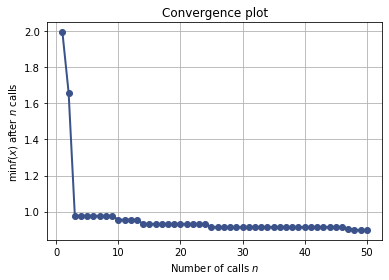

In [8]:
gp_results = gp_minimize(objective, space, n_calls=50, random_state=2019, callback=[plot_callback], n_jobs=-1)

In [9]:
from pprint import pprint

best_params = to_named_params(gp_results.x)
opt_params = {**static_params, **best_params}

print('Best params:')
pprint(best_params)

Best params:
{'colsample_bytree': 0.1,
 'gamma': 1e-05,
 'learning_rate': 0.06925444210310013,
 'max_depth': 21,
 'min_child_weight': 10,
 'reg_alpha': 0.00042641818076137844,
 'subsample': 0.8360375360205651}


# Skip HPO

If you want to skip HPO, use these params:

In [10]:
# from pprint import pprint

# best_params = {'colsample_bytree': 0.33475729690415135,
#  'gamma': 0.001,
#  'learning_rate': 0.0682585781151064,
#  'max_depth': 13,
#  'min_child_weight': 5,
#  'reg_alpha': 1e-05,
#  'subsample': 0.781029705398128}

# opt_params = {**static_params, **best_params}

# print('Best params:')
# pprint(opt_params)

## Inspect Model Performance

In [11]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

from config import raw_data_dir

seed=2019

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

# Create validation set for permutation importance
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

### Cross Validation Score

In [12]:
cv_scores = cross_val_score(get_xgb(**opt_params), X, y, scoring='neg_log_loss', n_jobs=-1, cv=StratifiedKFold(n_splits=3))

print('Cross validation score: {} (±{})'.format(np.mean(cv_scores)*-1, np.std(cv_scores)*-1))

KeyboardInterrupt: 

In [ ]:
# Fit model
best_model = get_xgb(**opt_params)
best_model.fit(X_train, y_train)

# Make predicitions ons validation set
val_preds = best_model.predict(X_val)

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, val_preds, labels=class_labels, output_dict=True))

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_val, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

### Feature Importances

In [ ]:
perm = PermutationImportance(best_model, random_state=seed).fit(X_val, y_val)

feat_imp = pd.DataFrame({'importance': perm.feature_importances_, 'names': X.columns}).sort_values(by='importance')

# Show only positive values
feat_imp = feat_imp[feat_imp.importance > 0]

plot = feat_imp.plot.barh(figsize=(12, 40), x='names')

## Make Submission

In [ ]:
from config import raw_data_dir, subs_dir

def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')
    
    print(len(new_sub), len(ids_list))

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = best_model.predict_proba(test_df)
test_ids = test_df.index.to_list()

sub_df = make_sub(predictions, test_ids)
sub_df.head()

In [ ]:
sub_df.to_csv(subs_dir / 'xgboost_data_v4_2.csv')